# Loan Default Prediction Report
---
**Author:** Tyler Chang | **Current Version Release Date:** September 27, 2023 | [GitHub]('https://github.com/Habeus-Crimpus') | [LinkedIn]('https://www.linkedin.com/in/tylerchang/') | [Data Portfolio]('https://troopl.com/tchang343w')

## Table of Contents
- [Report Summary](#heading-2)
- [Preparing the Data](#heading-2)
- [Exploring the Dataset](#heading-2)
- [Modeling the Data](#heading-2)

<a name="Heading-2"></a>
## Report Summary

Based on the [Coursera loan default prediction challenge]('https://www.coursera.org/projects/data-science-coding-challenge-loan-default-prediction#details') and using data available publicly [here]('https://www.kaggle.com/datasets/nikhil1e9/loan-default'), the report covers the importing, cleaning, analysis, visualization, and ultimate modeling of over 250k rows of loan taker data. This version of the report (version 1) culminates in two models with over 92% accuracy and similarly high performance across other metrics.

### Report Highlights

* Approximately 11.6% of the loans cataloged default.
* The average loan is approximately 2.18x that of the loan taker's income.
* The baseline accuracy is approximately 88.4%.
* XGBoosting and Random Forest models perform best across multiple metrics of classification success, beating the baseline accuracy by up to 5%.

<a name="header-2"></a>
## Preparing the Data

This section covers the importing of all required Python libraries, the data itself, and the process of cleaning the data.

### Loading the Required Libraries

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# machine learning 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# miscellaneous
from IPython import display
from pandasql import sqldf
import joblib

### Importing the Dataset

In [2]:
df = pd.read_csv('Loan_default.csv')

### Cleaning the Dataset

As a first step, let's look at the first five rows of the table so that we understand what types of information is available.

In [3]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


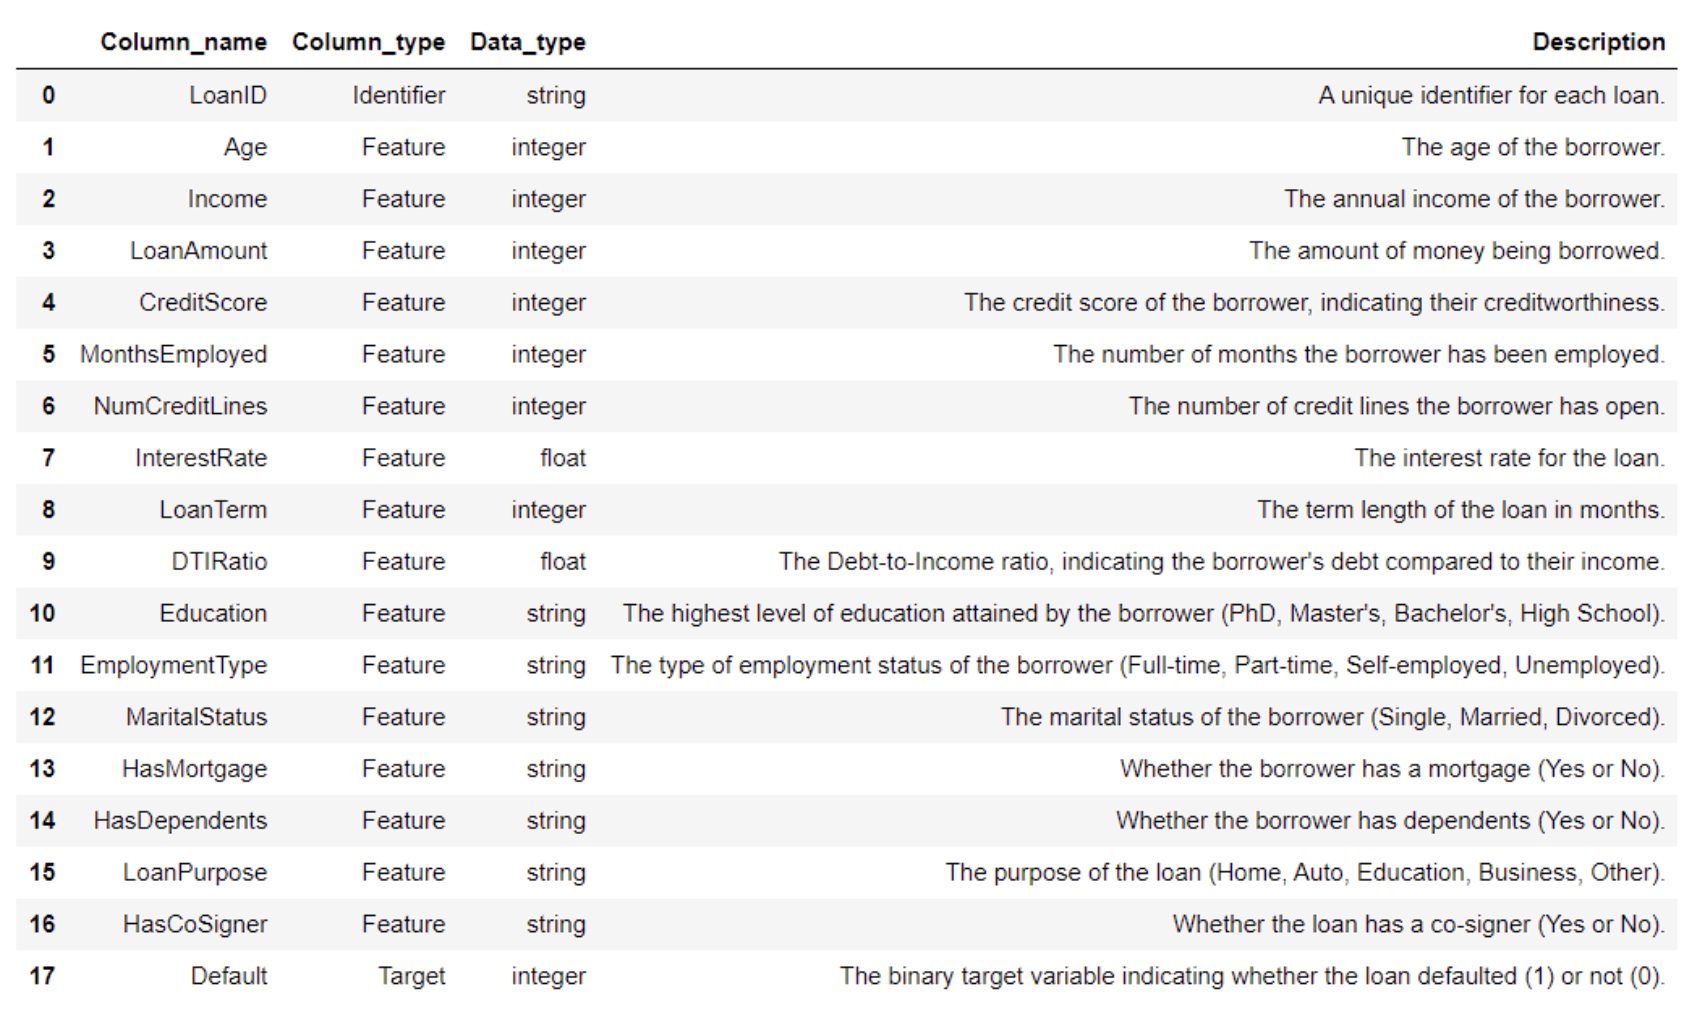

In [4]:
display.Image('Column_Descriptions.png')

The **Default** column is the what we want to be able to predict. Importantly, it contains only two possible values, 1 and 0, representing that a loan defaulted and that it did not, respectively. Since several of the columns are non-numeric, they will need to be encoded numerically before they can be used to make models. For now, however, it is more readable if they are left as text. 

Before proceeding on, a check for missing values must be done.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

All of the columns have 255,347 non-null values, meaning that there are no missing values. This does not mean that all the values are valid. In particular, none of the numeric columns (those marked as **int64** or **float64** in the table above) should have any negative values. To confirm this, we can look at the numeric summary table below.

In [6]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


All of the values seem appropriate for their respective subjects, meaning that the data is now ready for analysis.

<a name="heading-2"></a>
## Exploring the Dataset

We see from the above table that the average age of a loan taker is approximately 43 years old with the dataset including borrowers ranging from 18 to 69 years old. This age range is to be expected since most loan providers do not offer loans to minors and many seniors have already acquired the sorts of items (homes, education, cars, etc.) for loans are most often taken.

It is still important to check that we do not have an imbalance in the ages represented by the data. To check this, we can plot the distribution of the frequency of the ages.

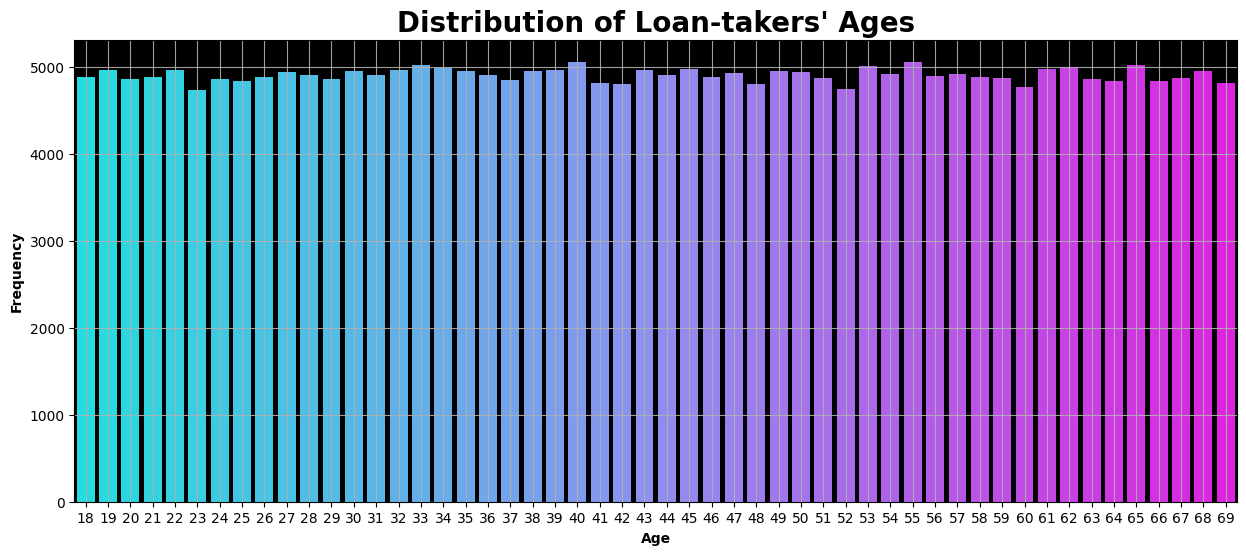

In [48]:
# counting the number of loan-taker for each age + sorting by age (ascending)
age_counts = pd.DataFrame(df.Age.value_counts().sort_index()).reset_index()
age_counts.columns = ['Age', 'Count']

# making the chart
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = 'Age', y = 'Count', data = age_counts, palette = 'cool')
plt.xlabel('Age', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title("Distribution of Loan-takers' Ages", weight = 'bold', size = 20)
ax.set_facecolor('black')
plt.grid(alpha = 0.9)
plt.show()

There are similar numbers of persons included in the dataset for each age. As a result, we can safely assume that any finding of later models or analysis are not a result of an imbalance in the ages represented in the data.

It is also worthwhile to look at the distributions of the incomes and size of the loans taken, which can be accomplished with the following chart.

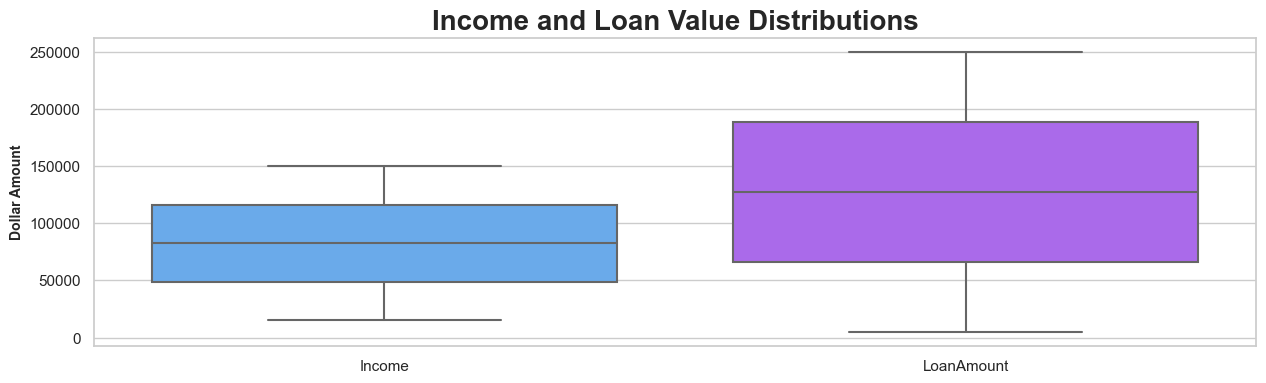

In [95]:
plt.figure(figsize=(15, 4))
sns.set(style = 'whitegrid')
sns.boxplot(df[['Income', 'LoanAmount']], palette='cool')
plt.ylabel('Dollar Amount', weight = 'bold', size = 10)
plt.title('Income and Loan Value Distributions', weight = 'bold', size = 20)
plt.show()

The incomes range from $15k to approximately $150k and the loan amounts range from $5k up to $249k. The majority of loan takers
had an imcome under $116k, which is lower than the average loan of $127.5k. This shows that the average loan is substantially larger than the average income but to better understand the relationship between the two measurements, we have to look at the difference between income and loan amount by loan taker.

In [67]:
# Calculating the net differnece between income and loan amount AND
# the percentage of a person's income that the loan represents.
'''
Note: The incLoanPerDiff (income loan percentage difference) is in terms of percent, meaning
that a value of 246.7 means that the loan is 246.7% of the loan takers income. 

The incLoanNetDiff is measuring the raw difference between a person's income and the loan
value. If the list value is positive, the person took a loan that is smaller than their 
income and if the value is negative, the loan is larger than the income.
''' 
incLoanNetDiff = []
incLoanPerDiff = []
for i in range(df.shape[0]):
    incLoanNetDiff.append(df.Income[i] - df.LoanAmount[i])
    incLoanPerDiff.append((df.LoanAmount[i] / df.Income[i])*100)    
    
# adding the new lists to the table
df['IncLoanNetDiff'] = incLoanNetDiff
df['IncLoanPerDiff'] = incLoanPerDiff

# displaying the numeric summary of the two new columns
df[['IncLoanNetDiff', 'IncLoanPerDiff']].describe()

,IncLoanNetDiff,IncLoanPerDiff
count,255347.000000,255347.000000
mean,-45079.560915,217.747982
std,80878.297292,217.835733
min,-234492.000000,3.374929
25%,-106751.000000,80.362790
50%,-44996.000000,154.672013
75%,16325.500000,267.174408
max,144721.000000,1653.245976


The average loan is approximately $45,079 greater than the loan taker's income and the loans total value represents approximatley 217.7% of their income. This is somewhat differently represented by the median loan-income difference
at $44,996 and the median percentage of income represented at approximately 154.7%. This implies that those taking 
loans larger than the median value are larger by a greater magnitude than those who take smaller loans are smaller. 

This is shown by the following two charts:

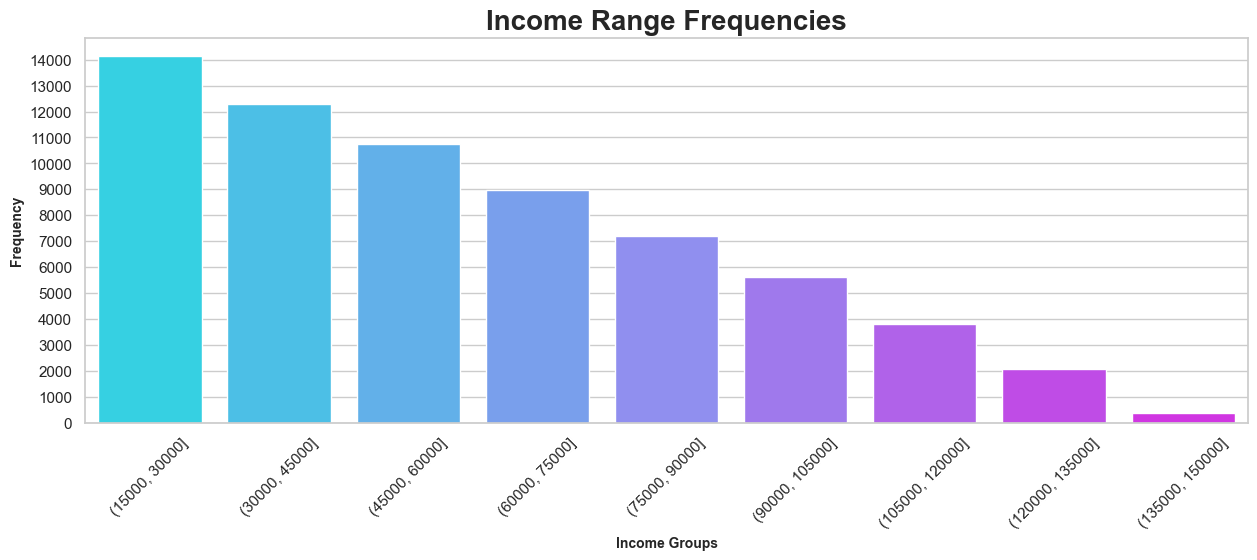

In [83]:
# defining bin edges for the IncLoanNetDiff column
diff_bin_edges = range(15000, 160000, 15000)

# making bins
df['IncLoanDiff_bins'] = pd.cut(df['IncLoanNetDiff'], bins = diff_bin_edges)

# Counting the frequency in each bin
income_counts = df.IncLoanDiff_bins.value_counts().reset_index()
income_counts.columns = ['Income Value', 'Count']

# plotting the IncLoanNetDiff frequency counts
plt.figure(figsize = (15, 5))
sns.set(style = 'whitegrid')
sns.barplot(x = 'Income Value', y = 'Count', data = income_counts, palette = 'cool')
plt.xlabel('Income Groups', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title('Income Range Frequencies', weight = 'bold', size =20)
plt.xticks(rotation = 45)
plt.yticks(list(range(0, 15000, 1000)))
plt.show()

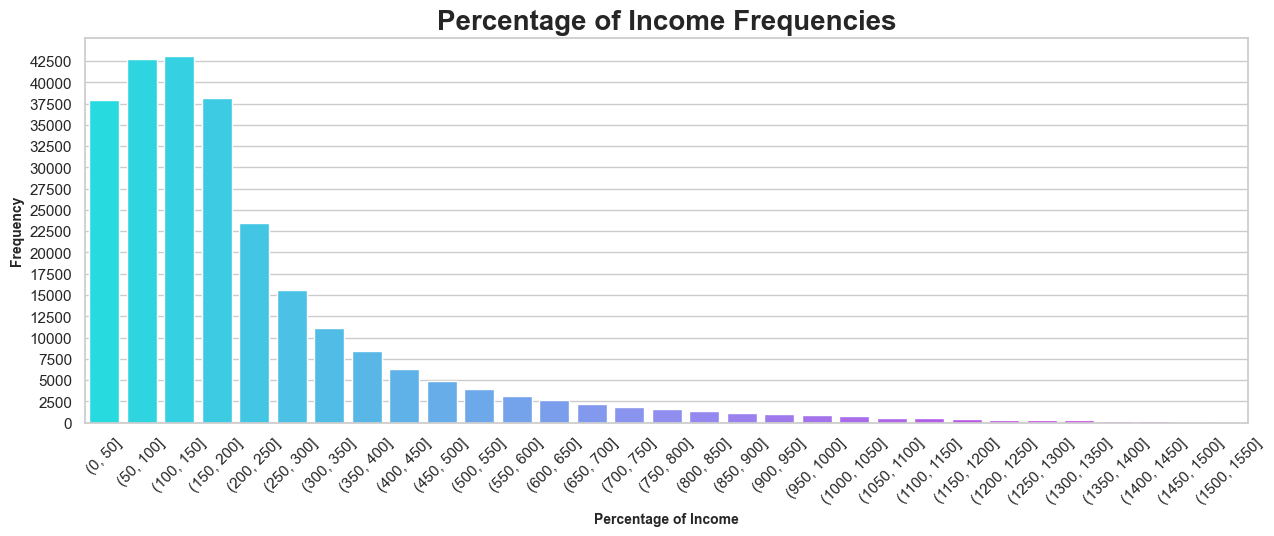

In [94]:
# defining bin edges for the IncLoanPerDiff column
per_bin_edges = range(0, 1600, 50)

# making bins
df['IncLoanPer_bins'] = pd.cut(df['IncLoanPerDiff'], bins = per_bin_edges)

# Counting the frequency in each bin
per_counts = df.IncLoanPer_bins.value_counts().reset_index()
per_counts.columns = ['Percentage Value', 'Count']

# plotting the IncLoanNetDiff frequency counts
plt.figure(figsize = (15, 5))
sns.set(style = 'whitegrid')
sns.barplot(x = 'Percentage Value', y = 'Count', data = per_counts, palette = 'cool')
plt.xlabel('Percentage of Income', weight = 'bold', size = 10)
plt.ylabel('Frequency', weight = 'bold', size = 10)
plt.title('Percentage of Income Frequencies', weight = 'bold', size =20)
plt.xticks(rotation = 45)
plt.yticks(list(range(0, 45000, 2500)))
plt.show()

The **Income Range Frequecies** chart is very positvely skewed with a consistently declining frequency as you go up in 
income group. This is somewhat expected since the most common reasons for taking loans--education, housing, healthcare, cars--
become less prohibitively expensive without loan assistance as your income goes up. 

The **Percentage of Income Frequencies** chart is also positively skewed with the largest groups being those borrowing between
50-100% and 100-150% of their income's value. There is a significant drop-off in loan takers after the percentage of income being borrowed exceeds 350% and this downward trend continues consistently for the rest of the percentage ranges. 

We can improve our understanding of the relationship between income and loan amount by plotting the relationship directly:

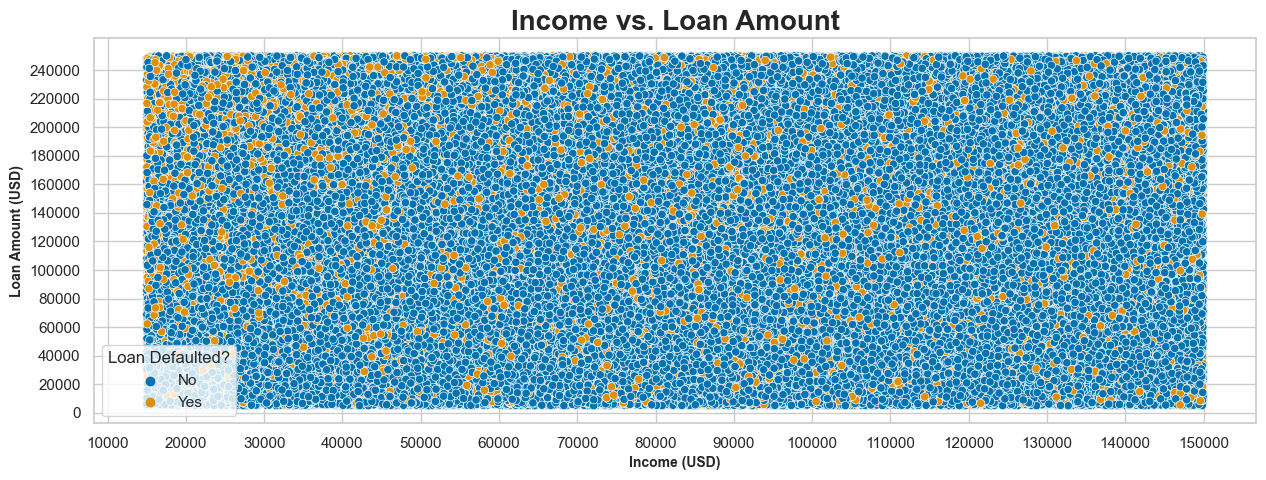

In [126]:
# adding a column to the table for coloring purposes
df['Default_word_ver'] = ['Yes' if val == 1 else 'No' for val in df.Default]

# plotting the incomes against their associated loan amounts
plt.figure(figsize = (15, 5))
sns.scatterplot(data = df, x = 'Income', y = 'LoanAmount', hue = 'Default_word_ver', palette='colorblind')
plt.legend(loc = 'lower left', title = 'Loan Defaulted?')
plt.xlabel('Income (USD)', weight = 'bold', size = 10)
plt.ylabel('Loan Amount (USD)', weight = 'bold', size = 10)
plt.title('Income vs. Loan Amount', weight = 'bold', size = 20)
plt.yticks(list(range(0,260000,20000)))
plt.xticks(list(range(10000,160000,10000)))
plt.show()

From this chart, we can see a few key findings:
* The vast majority of loans do not default.
* There is no apparent correlation between income level and loan amount. This might change if the data was subset by loan
purpose, credit score, marital status, and cosigner status.
* There is a higher number of defaulting loans on the lower side of the income range but there is a nontrivial number 
throughout the entire income range.

To make this more precise, we can visualize the default-to-no-default ratio as a pie chart.

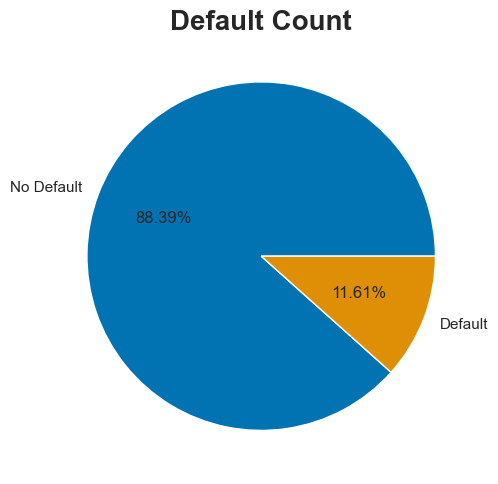

In [161]:
# counting the number of defaults/no defaults and the percentages they make up.
default_df = pd.DataFrame({'Category': ['No Default', 'Default'],
                           'Count': [df[df['Default']==0].count()['Default'],
                                     df[df['Default']==1].count()['Default']]})

# creating the data for the charts
count_data = [val for val in default_df.Count]

# making the pie chart
labels = ['No Default', 'Default']
palette_color = sns.color_palette('colorblind')
plt.figure(figsize=(15, 5))
plt.pie(count_data, labels = labels, colors = palette_color, autopct = '%1.2f%%')
plt.title('Default Count', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()

In [163]:
# Displaying the actual number in each of the above categories
default_df

,Category,Count
0,No Default,225694
1,Default,29653


There are 225,694 loans that did not default, accounting for approximately 88.39% of the borrowers, and 29,653 loans that
did default, making up the remaining 11.61%. So, while there are a large number of defaulting loans, they are far from being
the majority. As will be shown later, this imbalance in classes does have a significant effect on model performance and will 
be adjusted for later on.

Now, while income does affect the size of a loan that is accessible to a person, their credit score also tends to affect their eligibility. To start looking into the effect this has on the loans, let's first look at the how many people have a given credit score.

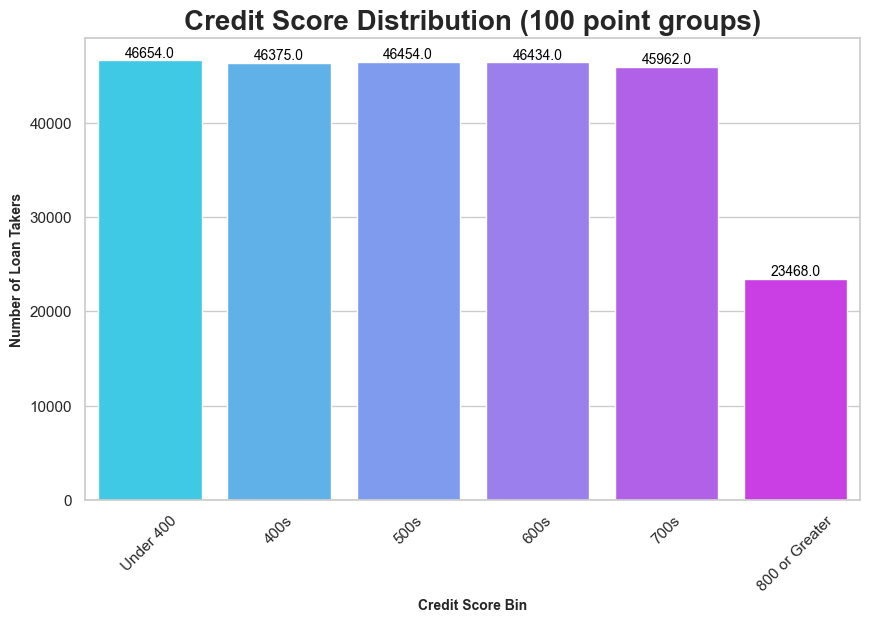

In [167]:
'''
I have chosen to make buckets out the credit scores since the results with the raw data are largely unreadable. The 
buckets are grouped by hundreds.
'''
# selecting only the credit score column
cred_scores = df.CreditScore
# Making the bins
cred_score_bins = []
for score in cred_scores:
    if score < 400:
        cred_score_bins.append('Under 400')
    elif score >= 400 and score < 500:
        cred_score_bins.append('400s')
    elif score >= 500 and score < 600:
        cred_score_bins.append('500s')
    elif score >= 600 and score < 700:
        cred_score_bins.append('600s')
    elif score >= 700 and score < 800:
        cred_score_bins.append('700s')
    else:
        cred_score_bins.append('800 or Greater')
# making the list of bins into a series
cred_score_bins = pd.Series(cred_score_bins)
# counting the counts for each bin
bin_counts = cred_score_bins.value_counts().reset_index()
reorder_dir = [0,3,1,2,4,5] # manually adjusting the order of the rows
bin_counts = bin_counts.iloc[reorder_dir]   # reordering the rows of the table
# making the bar chart
plt.figure(figsize=(10,6))
ax = sns.barplot(x = 'index', y = 'count', data = bin_counts, palette='cool')
plt.title('Credit Score Distribution (100 point groups)', weight = 'bold', size = 20)
plt.xlabel('Credit Score Bin', weight = 'bold', size = 10)
plt.ylabel('Number of Loan Takers', weight = 'bold', size = 10)
plt.xticks(rotation = 45)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2.,\
        p.get_height()), ha='center', va='center', fontsize=10, color='black',\
            xytext=(0, 5), textcoords='offset points')
plt.show()

In [171]:
# highest and lowest credit scores
df.CreditScore.max(), df.CreditScore.min()

(849, 300)

With the exception of those with a credit score of 800 or greater, there are very similar numbers of borrowers in each of the
credit score categories. The highest credit score in the dataset is 849, which helps to explain why there are fewer people in the 800+ credit score group. The lowest credit score being 300 makes the range of possible values for the under 400 category the same as all others besides 800 or greater, which might explain why we see similar frequency in the lowest category as we do with the middle ones.

We are now prepared to move onto modeling the data and making predictions.

<a name="header-2"></a>
## Modeling the Data

This section covers the preprocessing, modeling, and tuning of multiple supervised machine learning models for predicting
whether a given loan defaults. The models tested here include:
* Logistic Regression
* K-nearest Neighbors
* Decision Trees
* Random Forest
* Naive Bayes
* XGBoost

Since 88.39% of the loans did not default, we have a **baseline** accuracy of 0.8839. As will be discussed in the conclusion section, accuracy is not necessarily the most important metrics here. From a consumer point-of-view, having high precision is likely also important since it would minimize the number of people who are rejected for a loan because the model falsely predicts that they would default on the loan. Similarly, a business may be more concerned with recall because a high false negative rate would result in a greater number of loans being given to people who are more likely to default. 

As I will elaborate on later, **F1** and **ROC-AUC** (*area under the receiver operating characteristic) scores offer the best measurement of a model's performance since they represent a more balanced level of concern with both precision and recall. That said, the final models--XGBoost and Random Forest--both yield high values across all metrics so this does not turn out to be a serious concern. 

### Preprocessing the Data